## Sensitivity Analysis

This notebook evaluates the sensitivity of simulated one-way range observations with respect to variations 
in key dynamical and physical parameters. 

The goal is to quantify how uncertainties in parameters affect observable signals.

#### - Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tudatpy.interface import spice
from tudatpy import constants
from tudatpy.dynamics import environment_setup
from tudatpy.dynamics import propagation_setup
from tudatpy.dynamics import parameters_setup
from tudatpy.estimation import observable_models_setup
from tudatpy.estimation import observations_setup
from tudatpy.estimation import estimation_analysis
from tudatpy.estimation.observable_models_setup.links import LinkEndType
from tudatpy.estimation.observable_models_setup.model_settings import one_way_range
from tudatpy.astro import element_conversion
from tudatpy.astro.time_representation import DateTime

#### - Define SPICE Kernels and Simulation Epoch

In [2]:
spice.load_standard_kernels()

simulation_start_epoch = DateTime(2016, 10, 5).to_epoch()
propagation_start_epoch = simulation_start_epoch - 3600.0
simulation_end_epoch = simulation_start_epoch + 2*24*3600
propagation_end_epoch = simulation_end_epoch + 3600.0

#### - Create Celestial Bodies and Ground Station

In [3]:
bodies_to_create = ["Sun", "Jupiter", "Earth"]


global_frame_origin = "Jupiter"
global_frame_orientation = "ECLIPJ2000"


body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation
)

body_settings.add_empty_settings("Juno")
body_settings.get("Juno").constant_mass = 2000.0

bodies = environment_setup.create_system_of_bodies(body_settings)

In [4]:
environment_setup.add_ground_station(
bodies.get_body("Earth"),
"DSS-14",
np.array([0.0, 0.0, 0.0])
)

#### - Define Orbital Elements

In [5]:
jupiter_mu = constants.GRAVITATIONAL_CONSTANT * 1.898e27


semi_major_axis = 1.07e9
eccentricity = 0.95
inclination = np.deg2rad(90.0)
argument_of_periapsis = 0.0
longitude_of_ascending_node = 0.0
true_anomaly = 0.0


keplerian_elements = [
    semi_major_axis,
    eccentricity,
    inclination,
    argument_of_periapsis,
    longitude_of_ascending_node,
    true_anomaly
]

In [6]:
initial_state = element_conversion.keplerian_to_cartesian(
    keplerian_elements,
    jupiter_mu
)

In [7]:
spacecraft_name = "Juno"


acceleration_settings = {
    spacecraft_name: {
        "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
        "Sun": [propagation_setup.acceleration.point_mass_gravity()]
    }
}


acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    [spacecraft_name],
    ["Jupiter"]
)

In [8]:
integrator_settings = propagation_setup.integrator.runge_kutta_4(
    propagation_start_epoch,
    60.0
)

#### - Termination and Propagation Settings

In [9]:
termination_settings = propagation_setup.propagator.time_termination(
    propagation_end_epoch
)

In [10]:
propagator_settings = propagation_setup.propagator.translational(
    ["Jupiter"],
    acceleration_models,
    [spacecraft_name],
    initial_state,
    propagation_start_epoch,
    integrator_settings,
    termination_settings
)

#### - Observation Settings

In [11]:
link_ends = dict()

link_ends[LinkEndType.transmitter] = (
    observable_models_setup.links.body_origin_link_end_id("Juno")
)

link_ends[LinkEndType.receiver] = (
    observable_models_setup.links.body_reference_point_link_end_id(
    "Earth", "DSS-14"
    )
)

link_definition = observable_models_setup.links.LinkDefinition(link_ends)

In [12]:
observable_settings = [
    one_way_range(link_definition)
]

In [13]:
observation_times = np.arange(
    simulation_start_epoch,
    simulation_end_epoch,
    60.0
)

In [14]:
observation_simulators = observations_setup.observations_simulation_settings.create_observation_simulators(
    observable_settings,
    bodies
)

In [15]:
simulation_settings = observations_setup.observations_simulation_settings.tabulated_simulation_settings(
    observable_models_setup.model_settings.ObservableType.one_way_range_type,
    link_definition,
    observation_times
)

#### - Define parameters and estimate

In [16]:
parameter_settings = parameters_setup.initial_states(
    propagator_settings,
    bodies
)


parameters_to_estimate = parameters_setup.create_parameter_set(
    parameter_settings,
    bodies
)

In [17]:
estimator = estimation_analysis.Estimator(
    bodies,
    parameters_to_estimate,
    observable_settings,
    propagator_settings
)

In [18]:
observations = observations_setup.observations_wrapper.simulate_observations(
    [simulation_settings],
    estimator.observation_simulators,
    bodies
)

In [19]:
estimation_input = estimation_analysis.EstimationInput(
    observations
)

estimation_input.define_estimation_settings(
    reintegrate_variational_equations=True
)

In [20]:
estimation_output = estimator.perform_estimation(
    estimation_input
)

#### - Covariance matrix and parameter uncertainty

In [21]:
covariance_matrix = estimation_output.covariance
print(covariance_matrix)

[[ 4.25431492e+00 -1.79778928e+01 -2.82648333e+01  3.93734814e-02
  -4.95947641e-01 -2.74853156e-03]
 [-1.79778929e+01  8.03632581e+01  1.31466412e+02 -1.80726758e-01
   2.24184450e+00  1.16109328e-02]
 [-2.82648334e+01  1.31466412e+02  2.20774636e+02 -3.00941036e-01
   3.69573616e+00  1.82503187e-02]
 [ 3.93734814e-02 -1.80726758e-01 -3.00941036e-01  4.11378470e-04
  -5.06876014e-03 -2.54251928e-05]
 [-4.95947642e-01  2.24184450e+00  3.69573616e+00 -5.06876014e-03
   6.26981955e-02  3.20285436e-04]
 [-2.74853156e-03  1.16109328e-02  1.82503187e-02 -2.54251928e-05
   3.20285436e-04  1.77571255e-06]]


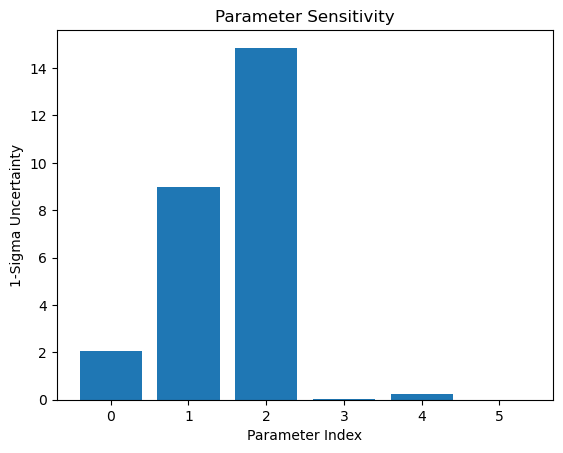

In [22]:
parameter_uncertainties = np.sqrt(np.diag(covariance_matrix))

plt.figure()
plt.bar(range(len(parameter_uncertainties)), parameter_uncertainties)
plt.xlabel("Parameter Index")
plt.ylabel("1-Sigma Uncertainty")
plt.title("Parameter Sensitivity")
plt.show()

## Conclusion

The z axis (parameter 2) tends to be more poorly observed, causing greater uncertainty in this position value. Furthermore, the simulation only takes two days of analysis, making the number of data small. With more data, uncertainty tends to decrease.